### Correlation analysis of India dataset, including some linear regression models

Key points:
- a central financial inclusion measure, bank account ownership, showed a strong relationship with urbanization levels
- several economic opportunity measures (LFPR, unemployment, household Gini) showed improvement for rural areas over urban areas, though within states rural wages still fall noticeably behind urban wages
- entreprenneurship, education levels, and micro- small- and medium-enterprise (MSME) lending are moderately to strongly correlated

Contents:
1. [Bank account ownership characteristics](#baoc)
2. [Some financial inclusion measures and urban / rural divides](#fimurd)
3. [Bank account ownership and labor demographics](#baold)
4. [Correlations among selected financial inclusion measures](#casfim)
5. [Correlations between the Aadhaar program and selected financial inclusion measures](#cbapsfim)
6. [Urban trends and EO/FI measures](#utefm)
7. [Savings and borrowing across different states](#sbads)
8. [Correlations among selected economic opportunity measures](#caseom)
9. [The rural / urban divide](#rud)
10. [Linear model: financial inclusion measure](#lmfim)
11. [Linear model: economic opportunity](#lmeo)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numbers
import math
from scipy import stats
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import statsmodels.formula.api as smf

In [2]:
file_path = ""

In [3]:
df_main = pd.read_csv(file_path+"India_team_4.csv")

For this analysis, we'll drop,
- Ladakh--this has the 2nd lowest population (300K), and has quite a few missing values, at least for the non-SDG data (like AIDIS (2019) and HCES (2022) data)
- Lakshadweep Islands and Andaman and Nicobar Islands--these are also low in population, and in the 1D analysis showed unusual behavior; they could be studied on their own, separately

In [4]:
# drop some states from the dataset
stateut_to_drop = ['Ladakh','Lakshadweep Islands','Andaman and Nicobar Islands']
df_main = df_main[~df_main['state_ut'].isin(stateut_to_drop)]

Some calculated columns will be useful--for example normalizing to per unit population.

In [5]:
# create some calculated columns
    # MSME credit "normalized" per capita (not sure how ~useful this is; vs eg divide by state GDP?)
df_main['msme_percap_2019'] = df_main['msme_credit_amt_2019']/df_main['Pop_2019']  # not sure what units
df_main['msme_percap_2022'] = df_main['msme_credit_amt_2022']/df_main['Pop_2022']
    # NFS payment app volume:
df_main['nfs_app_per'] = df_main['nfs_app_vol']/df_main['Pop_2022']  
    # female SHG loan amts:
df_main['shg_loans_per_2019'] = df_main['shg_loans_2019']/df_main['Pop_2019']  
df_main['shg_loans_per_2021'] = df_main['shg_loans_2021']/df_main['Pop_2021']

In [6]:
# normalizing social program fields (by population)
df_main['mgnrega_per_2019'] = df_main['mgnrega_2019']/df_main['Pop_2019']
df_main['mgnrega_per_2022'] = df_main['mgnrega_2022']/df_main['Pop_2022']
df_main['senior_help_per_2019'] = df_main['senior_help_2019']/df_main['Pop_2019']
df_main['senior_help_per_2022'] = df_main['senior_help_2022']/df_main['Pop_2022']
df_main['pension_nps_per_2019'] = df_main['pension_nps_2019']/df_main['Pop_2019']
df_main['pension_nps_per_2022'] = df_main['pension_nps_2022']/df_main['Pop_2022']

In [7]:
# increase (proportional) in wages 2022 over 2019:
df_main['wag_grw_tot_tot'] = (df_main['wag_tot_tot_2022']-df_main['wag_tot_tot_2019'])/df_main['wag_tot_tot_2019']
# time use ratio, female to male, in unpaid domestic work:
df_main['tus_tot_dom_ratio'] = df_main['tus_tot_male_domestic_mins']/df_main['tus_tot_female_domestic_mins']
# increase (proportional) in acc_per_per 2022 over 2019:
df_main['acc_grw_per_per'] = (df_main['acc_per_per_2022']-df_main['acc_per_per_2019'])/df_main['acc_per_per_2019']
# increase (proportional) in unemployment, unemp_tot_per 2022 over 2019:
df_main['unemp_inc_tot_per'] = (df_main['unemp_tot_per_2022']-df_main['unemp_tot_per_2019'])/df_main['unemp_tot_per_2019']
# aggregate total of activity in subset of startup categories, normalized:
df_sub = df_main[['su_fintech', 'su_telecom', 'su_energy', 'su_media', 'su_healthcare', 'su_greentech', 'su_agri', 'su_biotech', 'su_chem', 'su_educ']]
df_main['su_aggregate'] = df_sub.sum(axis=1)/df_main['Pop_2022']
# poverty index change proportion, 2015 to 2019:
df_main['poverty_chg'] = (df_main['poverty_multi_tot_2019']-df_main['poverty_multi_tot_2015']) / df_main['poverty_multi_tot_2015']
# coarse estimate of proportion in urban growth, 2011 vs 2021
df_main['urb_grow'] = (df_main['urb_pct_2021']-df_main['urb_pct_2011'])/df_main['urb_pct_2011']

In [19]:
df_main.info()

<class 'pandas.core.frame.DataFrame'>
Index: 33 entries, 1 to 35
Columns: 320 entries, state_ut to poverty_chg
dtypes: float64(229), int64(90), object(1)
memory usage: 82.8+ KB


In [8]:
# utility function, for creating select scatterplots
def scatter_pairs(df, column_pairs):

    num_plots = len(column_pairs)
    if num_plots == 0:
        print("No column pairs provided.")
        return

    # Calculate grid size
    ncols = math.ceil(math.sqrt(num_plots))
    nrows = math.ceil(num_plots / ncols)

    fig, axes = plt.subplots(nrows, ncols, figsize=(4 * ncols, 3 * nrows))
    if num_plots ==1:
        axes = [axes]
    else:
        axes = axes.flatten()  # Flatten in case it's a 2D array

    for i, (x_col, y_col) in enumerate(column_pairs):
        ax = axes[i]
        if x_col in df.columns and y_col in df.columns:
            ax.scatter(df[x_col], df[y_col], alpha=0.7)
            ax.set_xlabel(x_col)
            ax.set_ylabel(y_col)
            ax.set_title(f'{y_col} vs {x_col}')
        else:
            ax.set_visible(False)
            print(f"Warning: Columns '{x_col}' or '{y_col}' not found in DataFrame.")

    # Hide any unused subplots
    for j in range(i + 1, len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

In [8]:
# population by state (in 1000s)
df_sub = df_main[['state_ut','Pop_2021']]
df_sub_srt = df_sub.sort_values(by=['Pop_2021'])
df_sub_srt

,state_ut,Pop_2021
18,Lakshadweep Islands,68
17,Ladakh,298
0,Andaman and Nicobar Islands,401
29,Sikkim,680
7,Dadra & Nagar Haveli and Daman & Diu,1132
5,Chandigarh,1215
23,Mizoram,1221
2,Arunachal Pradesh,1540
9,Goa,1563
26,Pondicherry,1593


### Bank account ownership characteristics <a name="baoc"></a>

Fields were selected that might be directly related to bank account ownership. Most are intuitive. The field school_elec was chosen as proxy for state development levels.

The correlation plot shows moderate/high correlations between account ownership in
commercial accounts and (1) urban density, (2) education levels, (3) household 
expenditures. Note however that at this state-wise averaging level, urban density, education 
levels, total wages, and household expenditures are also moderately correlated in various ways. These factors are generally correlated with wealth. So this is probably showing, for example, both a relationship between account ownership and urbanization, as well as an underlying relationship between account ownership and wealth.

For the specific scatterplots, there are outliers that may have significance in skewing the
correlation values. Further exploration of outliers may be helpful.

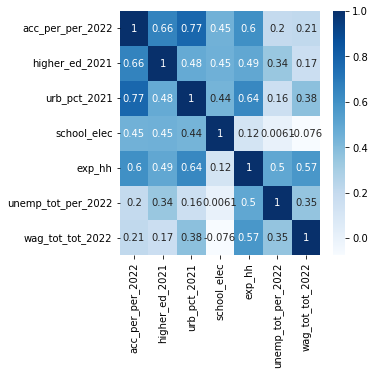

In [9]:
# correlations between a main bank account ownership metric and some other select 
# fields
df_sub = df_main[['acc_per_per_2022', 'higher_ed_2021', 'urb_pct_2021', 'school_elec', 
                  'exp_hh', 'unemp_tot_per_2022','wag_tot_tot_2022']]
corr_1 = df_sub.corr()
fig, ax = plt.subplots(figsize=(4.5,4.5)) 
sns.heatmap(corr_1,cmap="Blues",annot=True,ax=ax)
plt.show()

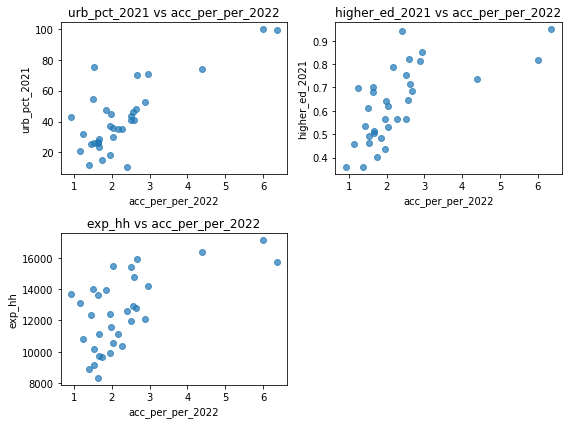

In [10]:
scatter_pairs(df_main, [('acc_per_per_2022','urb_pct_2021'),
                       ('acc_per_per_2022','higher_ed_2021'),
                       ('acc_per_per_2022','exp_hh')])

### Some financial inclusion measures and urban / rural divides <a name="fimurd"></a>

Again, urbanization shows moderate/strong correlation with commercial bank account
ownership. Also, some of the FI measures are moderately correlated. This is somewhat
expected. The grouping, digital_payment_per_capita, acc_per_per_2022, and acct_comm all have
moderate inter-correlations (0.5 or higher). And these other FI measures are showing
correlations with urbanization as well. Overall, there definitely seems to be a relationship
between urbanization and financial inclusion measures.

One notable moderate correlation, is a negative correlation (-0.48) between agricultural
wages and digital_payment_per_capita. However the associated scatterplot shows this is probably mostly the result of an extreme outlier. Other scatterplots also show outliers, and also might be worth following up on.

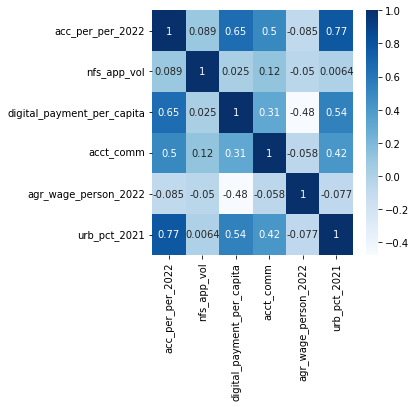

In [11]:
df_sub = df_main[['acc_per_per_2022', 'nfs_app_vol', 'digital_payment_per_capita', 'acct_comm', 'agr_wage_person_2022', 'urb_pct_2021']]
corr_1 = df_sub.corr()
fig, ax = plt.subplots(figsize=(4.5,4.5)) 
sns.heatmap(corr_1,cmap="Blues",annot=True,ax=ax)
plt.show()


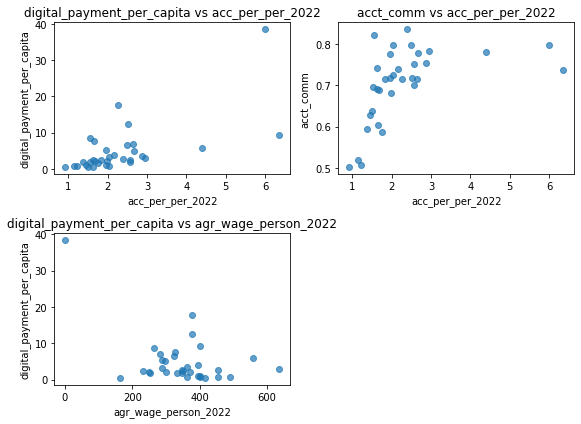

In [12]:
col_pairs = [('acc_per_per_2022', 'digital_payment_per_capita'),
    ('acc_per_per_2022', 'acct_comm'),
    ('agr_wage_person_2022', 'digital_payment_per_capita')]
scatter_pairs(df_main,col_pairs)

### Bank account ownership and labor demographics <a name="baold"></a>

The correlations between bank account ownership, measured with acc_per_per_2022, and
selected labor force measures, show mostly low correlations. Overall, it's difficult
to see much significance without further checks. Also, this is quite limited by state
level aggregation.

The larger-magnitude correlations involve rural unemployment for females, labor
force participation for rural females, and casual wages for males. Again, there are
notable outliers that may be having a significant effect on the correlation values. 
Examining these outliers might be helpful for further analysis.

In [13]:
bank_col = 'acc_per_per_2022'   # what to use for correlations
against_col = ['unemp_rur_mal_2022', 'unemp_rur_fem_2022', 'unemp_rur_per_2022', 
               'unemp_urb_mal_2022', 'unemp_urb_fem_2022', 'unemp_urb_per_2022', 
               'unemp_tot_mal_2022', 'unemp_tot_fem_2022', 'unemp_tot_per_2022',
               'lfpr_rur_mal_2022', 'lfpr_rur_fem_2022', 'lfpr_rur_per_2022', 
               'lfpr_urb_mal_2022', 'lfpr_urb_fem_2022', 'lfpr_urb_per_2022', 
               'lfpr_tot_mal_2022', 'lfpr_tot_fem_2022', 'lfpr_tot_per_2022',
                'cas_wage_male_2022', 'cas_wage_female_2022', 'cas_wage_person_2022', 
               'fem_manage_ratio_2022', 'wag_urb_urb_2022', 'wag_urb_urb_ratio_2022', 
               'wag_rur_rur_2022', 'wag_rur_rur_ratio_2022']
df_sub = df_main[[bank_col]+against_col]
corr_1 = df_sub.corrwith(df_sub[bank_col])[1:]

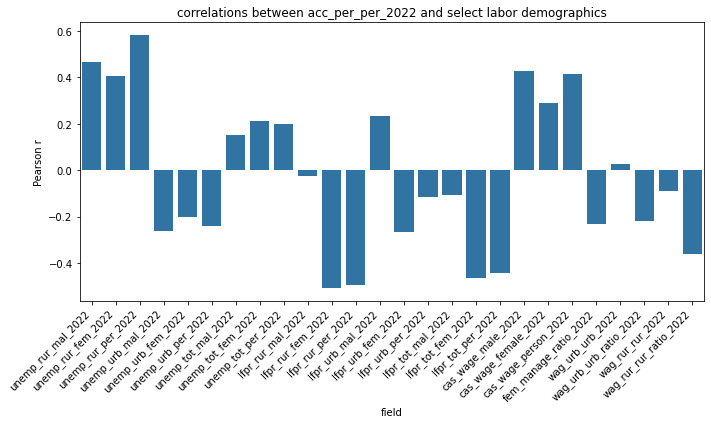

In [14]:
df_1 = corr_1.reset_index()
df_1.columns = ['Categories', 'Values']

plt.figure(figsize=(10, 6))
sns.barplot(data=df_1, x='Categories', y='Values')

# Customization
plt.xlabel('field')
plt.ylabel('Pearson r')
plt.title('correlations between acc_per_per_2022 and select labor demographics')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

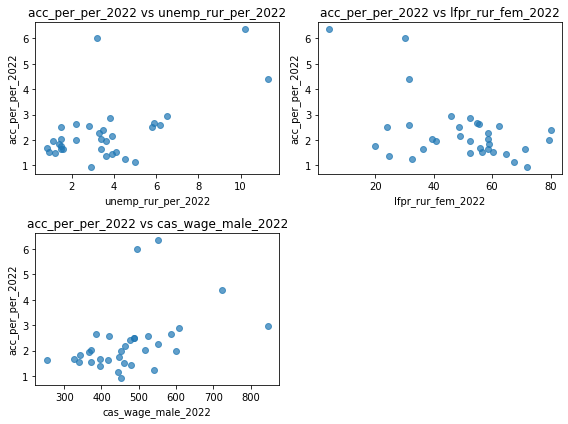

In [15]:
col_pairs = [('unemp_rur_per_2022', 'acc_per_per_2022'),
    ('lfpr_rur_fem_2022', 'acc_per_per_2022'),
    ('cas_wage_male_2022', 'acc_per_per_2022')]
scatter_pairs(df_main,col_pairs)

### Correlations among selected financial inclusion measures <a name="casfim"></a>

Here, Pearson correlations are checked among FI measures. There are several moderate 
correlations among these measures, which is expected. The set of strongest correlations 
are between bank accounts per person in 2022 (acc_per_per_2022) and three other measures, 
acc_grw_per_per, nfs_app_per, and digital_payment_per_capita. Some of these inter-
correlations were shown in scatterplots above. Additional scatterplots below show, again,
the presence of outliers, so drawing conclusions from just the correlation coefficient
may be somewhat unreliable.

The strongest relations that seem safe from outliers are,
again, expected--between acc_per_per_2022 and both nfs_app_per and digital_payments_per_capita.

In [16]:
fi_measures = ['acct_comm','acc_per_per_2022','acc_grw_per_per',
                    'nfs_app_per','digital_payment_per_capita','pay_ewal_used',
                   'pay_cd_used','pension_nps_per_2022']

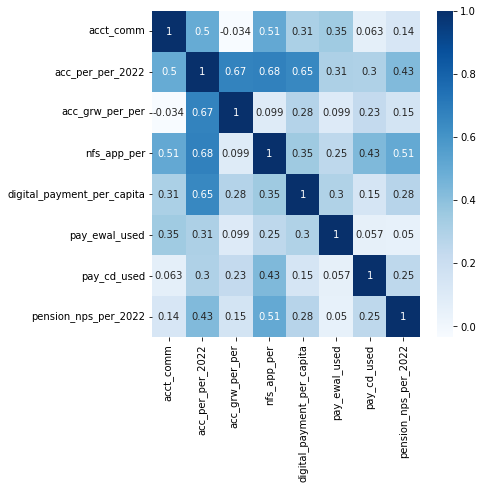

In [17]:
# Pearson correlations among FI measures;
corr_1 = df_main[fi_measures].corr()
fig, ax = plt.subplots(figsize=(6,6)) 
sns.heatmap(corr_1,cmap="Blues",annot=True,ax=ax)
plt.show()

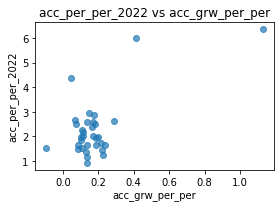

In [18]:
col_pairs = [('acc_grw_per_per','acc_per_per_2022')]
scatter_pairs(df_main,col_pairs)

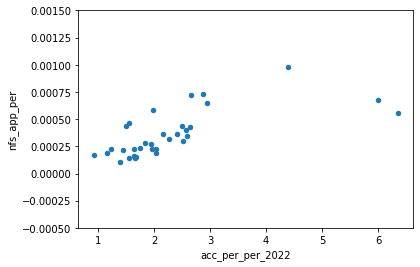

In [19]:
df_main.plot.scatter(x='acc_per_per_2022',y='nfs_app_per')
plt.ylim(-0.0005,0.0015)
plt.show()

### Correlations between the Aadhaar program and selected financial inclusion measures <a name="cbapsfim"></a>

There is a moderate-high correlation (0.74) between Aadhaar enrollment and one of the main 
financial inclusion measures, acct_comm (proportion of accounts held at commercial banks
by the population, 2019). Lower correlations (0.56, 0.47) exist between Aadhaar and acc_per_per_2022 (another commercial account ownership measure), and nfs_app_per (a measure of digital banking through the NFS), respectively. Scatterplots reinforce these correlations, with especially several outliers for the acc_per_per_2022 plot that might be further studied--otherwise this correlation would likely have been stronger.

In a similar way, other fields were checked against Aadhaar enrollment (not shown). Other high correlations existed between Aadhaar enrollment and,
- school_elec (r=0.68)
- mgnrega_per_2022 (r=-0.60)
- higher_ed_2021 (r=0.68)
- acct_comm (r=0.74)

One possibility is that Aadhaar enrollment tracks with state development, given that school_elec was chosen as proxy for state development, the MGNREGA program targets rural poverty, and higher_ed_2021 tends to correlate with state micro / small / medium business lending (MSME) and entreprenneurship (shown under the "Correlations among selected economic opportunity measures" heading below). The link between Aadhaar and both the important financial inclusion metric of account ownership, and state development, reinforces the result above, under the "Bank account ownership characteristics" heading, that financial inclusion and urbanization are well-correlated.

In [20]:
aad_col = 'pop_on_Aadhaar_pct'   # what to use for correlations
against_col = fi_measures
df_sub = df_main[[aad_col]+against_col]
corr_1 = df_sub.corrwith(df_sub[aad_col])
print(corr_1[1:])

acct_comm                     0.735806
acc_per_per_2022              0.560593
acc_grw_per_per               0.209693
nfs_app_per                   0.465950
digital_payment_per_capita    0.255865
pay_ewal_used                 0.312423
pay_cd_used                  -0.007734
pension_nps_per_2022         -0.014908
dtype: float64


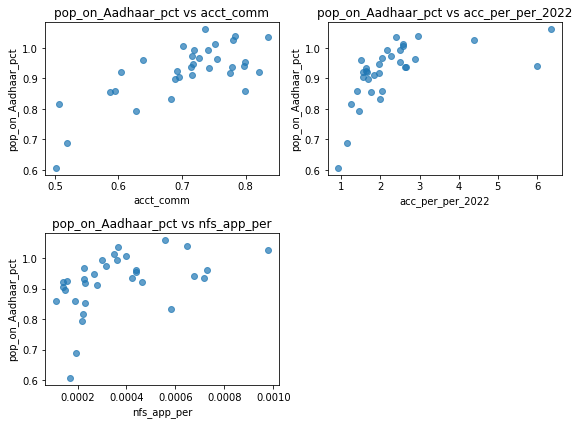

In [21]:
scatter_pairs(df_main, [('acct_comm','pop_on_Aadhaar_pct'),
                       ('acc_per_per_2022','pop_on_Aadhaar_pct'),
                       ('nfs_app_per','pop_on_Aadhaar_pct')])

### Urban trends and EO/FI measures <a name="utefm"></a>

Do trends toward urbanization correlate with either EO or FI measures? A simple measure of urbanization trends is created by considering the proportional change in urban density between 2011 and 2021. All the correlations are moderate to mild, with all but one < 0.50. The two measures most correlated with the measure of urban growth are fem_manage_ratio_2022 (proportion of females among managers) and tus_tot_dom_ratio (ratio of time spent in unpaid domestic work, men to women). So growth in urbanization may track with greater gender parity. Other, lower correlations indicate urban growth correlates with both higher pension enrollments and higher labor force participation rates. Scatterplots for the four highest correlations in some cases show large outliers possibly having a large influence on the correlation.

In [23]:
eo_measures = ['gini_rur_hh_2022','gini_urb_hh_2022','unemp_tot_per_2022',
              'unemp_inc_tot_per','lfpr_tot_per_2022','msme_percap_2022',
              'higher_ed_2021','stud_marks_mean','wag_tot_tot_ratio_2022',
               'wag_grw_tot_tot','tus_tot_person_domestic_mins',
              'fem_manage_ratio_2022','tus_tot_dom_ratio','su_aggregate',
              'poverty_multi_tot_2019']

In [24]:
urg_col = 'urb_grow'   # what to use for correlations
against_col = fi_measures+eo_measures
df_sub = df_main[[urg_col]+against_col]
corr_1 = df_sub.corrwith(df_sub[urg_col])[1:]

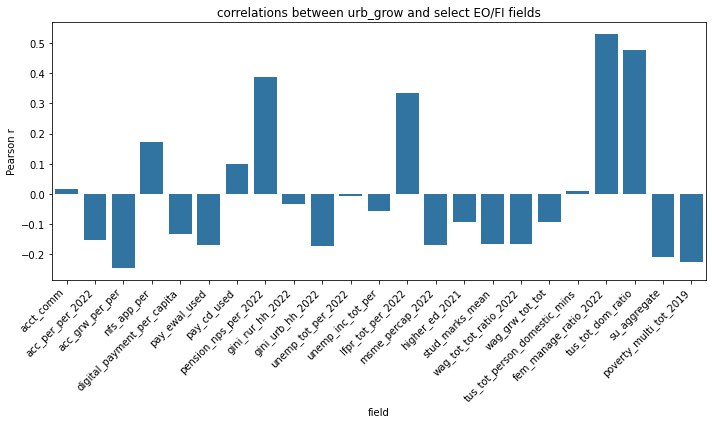

In [25]:
df_1 = corr_1.reset_index()
df_1.columns = ['Categories', 'Values']

plt.figure(figsize=(10, 6))
sns.barplot(data=df_1, x='Categories', y='Values')

# Customization
plt.xlabel('field')
plt.ylabel('Pearson r')
plt.title('correlations between urb_grow and select EO/FI fields')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

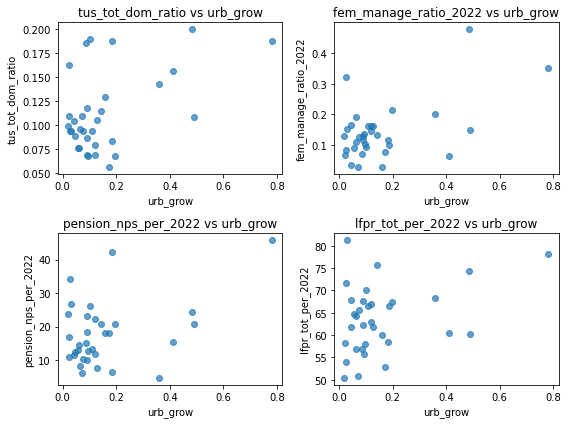

In [26]:
scatter_pairs(df_main, [('urb_grow','tus_tot_dom_ratio'),
                       ('urb_grow','fem_manage_ratio_2022'),
                       ('urb_grow','pension_nps_per_2022'),
                       ('urb_grow','lfpr_tot_per_2022')])

### Savings and borrowing across different states <a name="sbads"></a>

A staggered bar chart shows variations between states in borrowing behavior, and uses
state-wide average of commercial account ownership as proxy for savings. Again, outliers
stand out, like for Chandigarh and large regular loan amounts, or Sikkim, with
large kind loan values.

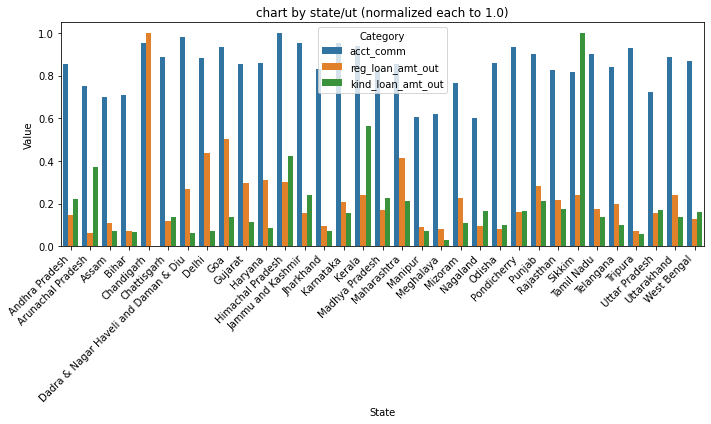

In [27]:
# this relies on AIDIS (2019) survey data
sb_measures = ['acct_comm', 'reg_loan_amt_out', 'kind_loan_amt_out']
df_sub = df_main[['state_ut']+sb_measures]

# normalize values to max of 1.0
for col in sb_measures:
    df_sub.loc[:,col] = df_sub[col]/max(df_sub[col])

df_long = df_sub.melt(id_vars='state_ut', value_vars=sb_measures,
                  var_name='Category', value_name='Value')

# Plot with seaborn
plt.figure(figsize=(10, 6))
sns.barplot(data=df_long, x='state_ut', y='Value', hue='Category')

# Customization
plt.xlabel('State')
plt.ylabel('Value')
plt.title('chart by state/ut (normalized each to 1.0)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Category')
plt.tight_layout()
plt.show()

### Correlations among selected economic opportunity measures <a name="caseom"></a>

Most of the correlations are relatively low (<0.35). The biggest correlation is between the aggregate entreprenneurship measure, su_aggregate, and the MSME (micro and small business) lending program. Also correlated with startup measures are education levels and student test scores--so perhaps there are "tech heavy" states that encourage entreprenneurship and tech (etc) talent--this goes another "direction" in that those student education levels also correlate fairly strongly with MSME lending. Though what causes what is uncertain, this 
might support the idea that the MSME program is helping to foster entreprenneurship.

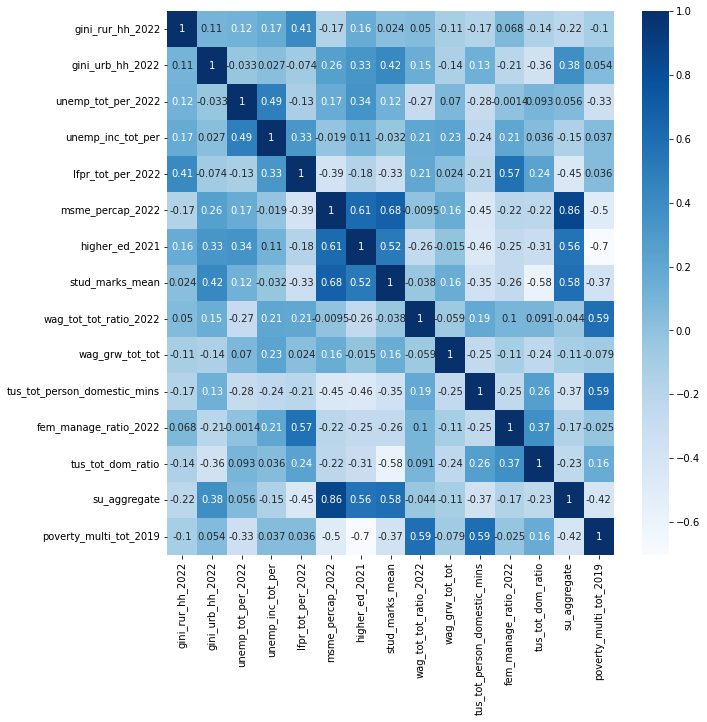

In [28]:
corr_1 = df_main[eo_measures].corr()
fig, ax = plt.subplots(figsize=(10,10)) 
sns.heatmap(corr_1,cmap="Blues",annot=True,ax=ax)
plt.show()

### The rural-urban divide <a name="rud"></a>

Poverty rates tend to be worse in rural areas. India's rural-urban gap in poverty has been closing rapidly, especially the past few years. Some reports as of 2025 suggest the gap between rural and urban poverty has fallen to as little as 1%. Here various fields in the data related to economic opportunity, that also contain urban / rural splits, are compared by ratios. The ratios are oriented so that higher values show greater disparity against rural households. For example the ratio of Gini coefficients has rural divided by urban--so a high rural Gini (high inequality) divided by a low urban Gini (low inequality) would give a high value (bad for rural). 

The data is sorted in order of urban density. A staggered bar plot shows the ratios in that order, with an additional line plot below showing the urban density in each state (black line). Three elements stand out:
- outside of a few high-density urban states, the ratios are < 1, indicating favorable measures for rural workers
- the ratio of rural unemployed to urban unemployed within each state decreases as states become more rural; this is also good for rural workers in rural states, though perhaps at the expense of urban workers in those states
- however, across all levels of urbanization, there is a persistent wage imbalance: urban workers earn higher wages than rural workers

In [29]:
# create some more calculated fields, looking at rural/urban ratios for select measures
df_main['gini_ru_ratio'] = df_main['gini_rur_hh_2022']/df_main['gini_urb_hh_2022']
df_main['unemp_ru_ratio'] = df_main['unemp_rur_per_2022']/df_main['unemp_urb_per_2022']
df_main['lfpr_ur_ratio'] = df_main['lfpr_urb_per_2022']/df_main['lfpr_rur_per_2022']
df_main['wage_ur_ratio'] = df_main['wag_urb_urb_2022']/df_main['wag_rur_rur_2022']

In [30]:
df_sub = df_main[['state_ut','urb_pct_2021','gini_rur_hh_2022','gini_ru_ratio','unemp_ru_ratio',
                 'lfpr_ur_ratio','wage_ur_ratio']]
df_sub_srt = df_sub.sort_values(by=['urb_pct_2021'],ascending=False).reset_index(drop=True)

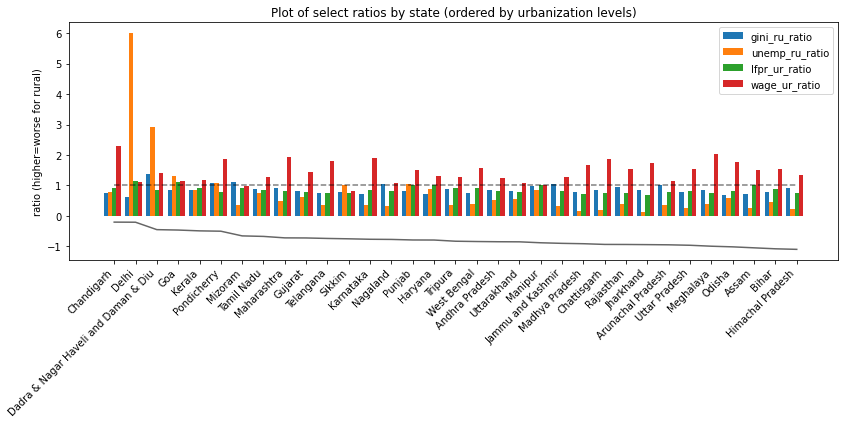

In [31]:
# Plot setup
x = np.arange(len(df_sub_srt))  # numeric x positions
width = 0.20  # bar width

fig, ax = plt.subplots(figsize=(12, 6))

# Bar plot for ratios
bars1 = ax.bar(x - 2*width, df_sub_srt['gini_ru_ratio'], width, label='gini_ru_ratio')
bars2 = ax.bar(x - width, df_sub_srt['unemp_ru_ratio'], width, label='unemp_ru_ratio')
bars2 = ax.bar(x, df_sub_srt['lfpr_ur_ratio'], width, label='lfpr_ur_ratio')
bars2 = ax.bar(x + width, df_sub_srt['wage_ur_ratio'], width, label='wage_ur_ratio')


# State names on x-axis
ax.set_xticks(x)
ax.set_xticklabels(df_sub_srt['state_ut'], rotation=45, ha='right')

# Axis labels
ax.set_ylabel("ratio (higher=worse for rural)")
ax.set_title("Plot of select ratios by state (ordered by urbanization levels)")
ax.legend()

y_rug = -0.05 * df_sub_srt[['gini_ru_ratio','unemp_ru_ratio',
                 'lfpr_ur_ratio','wage_ur_ratio']].values.max()  # e.g., 5% below zero

# line plot showing (ordered) urbanization levels
ax.plot(x, df_sub_srt['urb_pct_2021']/100-1.2, linestyle='-', color='black', alpha=0.6)

# horizontal line at ratio = 1
ax.plot(x,[1.0]*(len(df_sub_srt)),linestyle='dashed',color='black',alpha=0.5)

plt.tight_layout()
plt.show()

### Linear model: financial inclusion measure <a name="lmfim"></a>

A linear regression model is built, with the outcome variable one of the main financial inclusion measures available in the data: the number of commercial bank accounts (deposit and credit) held per person in 2022 (acc_per_per_2022). A small set of predictors was selected for likely impact on the outcome variable. Further screening involved checking for pairwise correlations, and variance inflation factors (VIF). (The procedure here follows that of a useful refresher on careful linear regression: Zuur et al, "A protocol for data exploration to avoid common statistical problems" (2010), https://besjournals.onlinelibrary.wiley.com/doi/full/10.1111/j.2041-210X.2009.00001.x)

In [76]:
# a set of selected predictors, based on what likely might affect bank account ownership
x_cols = ['urb_pct_2021','higher_ed_2021','wag_tot_tot_2022',
         'teledensity_pct','lfpr_tot_per_2022','pension_nps_per_2022',
         'fem_manage_ratio_2022','gini_rur_hh_2022','gini_urb_hh_2022']

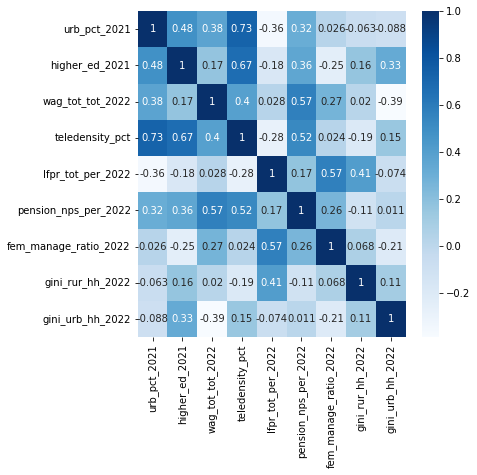

In [77]:
# check for correlations in predictors;
# correlations are fairly mild with only 2 above 0.50: pension / wage total and
# female manager / LFPR;
# teledensity however is quite highly correlated with two others--so probably remove
df_sub = df_main[x_cols]
corr_1 = df_sub.corr()
fig, ax = plt.subplots(figsize=(6,6)) 
sns.heatmap(corr_1,cmap="Blues",annot=True,ax=ax)
plt.show()

In [78]:
x_cols.remove('teledensity_pct')
df_xx = df_main[x_cols]

A pairplot or scatterplot matrix of proposed variables, to check distributions and outliers. 

For outliers, in fem_manager_ratio_2022, Nagaland (not highlighted) is highish outlier (at 0.47). (Nagaland's population is 2.2M; it had some unusual outliers in 1D plots, for unemployment).

In general, note the first row--there are several predictors that look promising for some degree of linear influence on acc_per_per_2022 outcome variable.

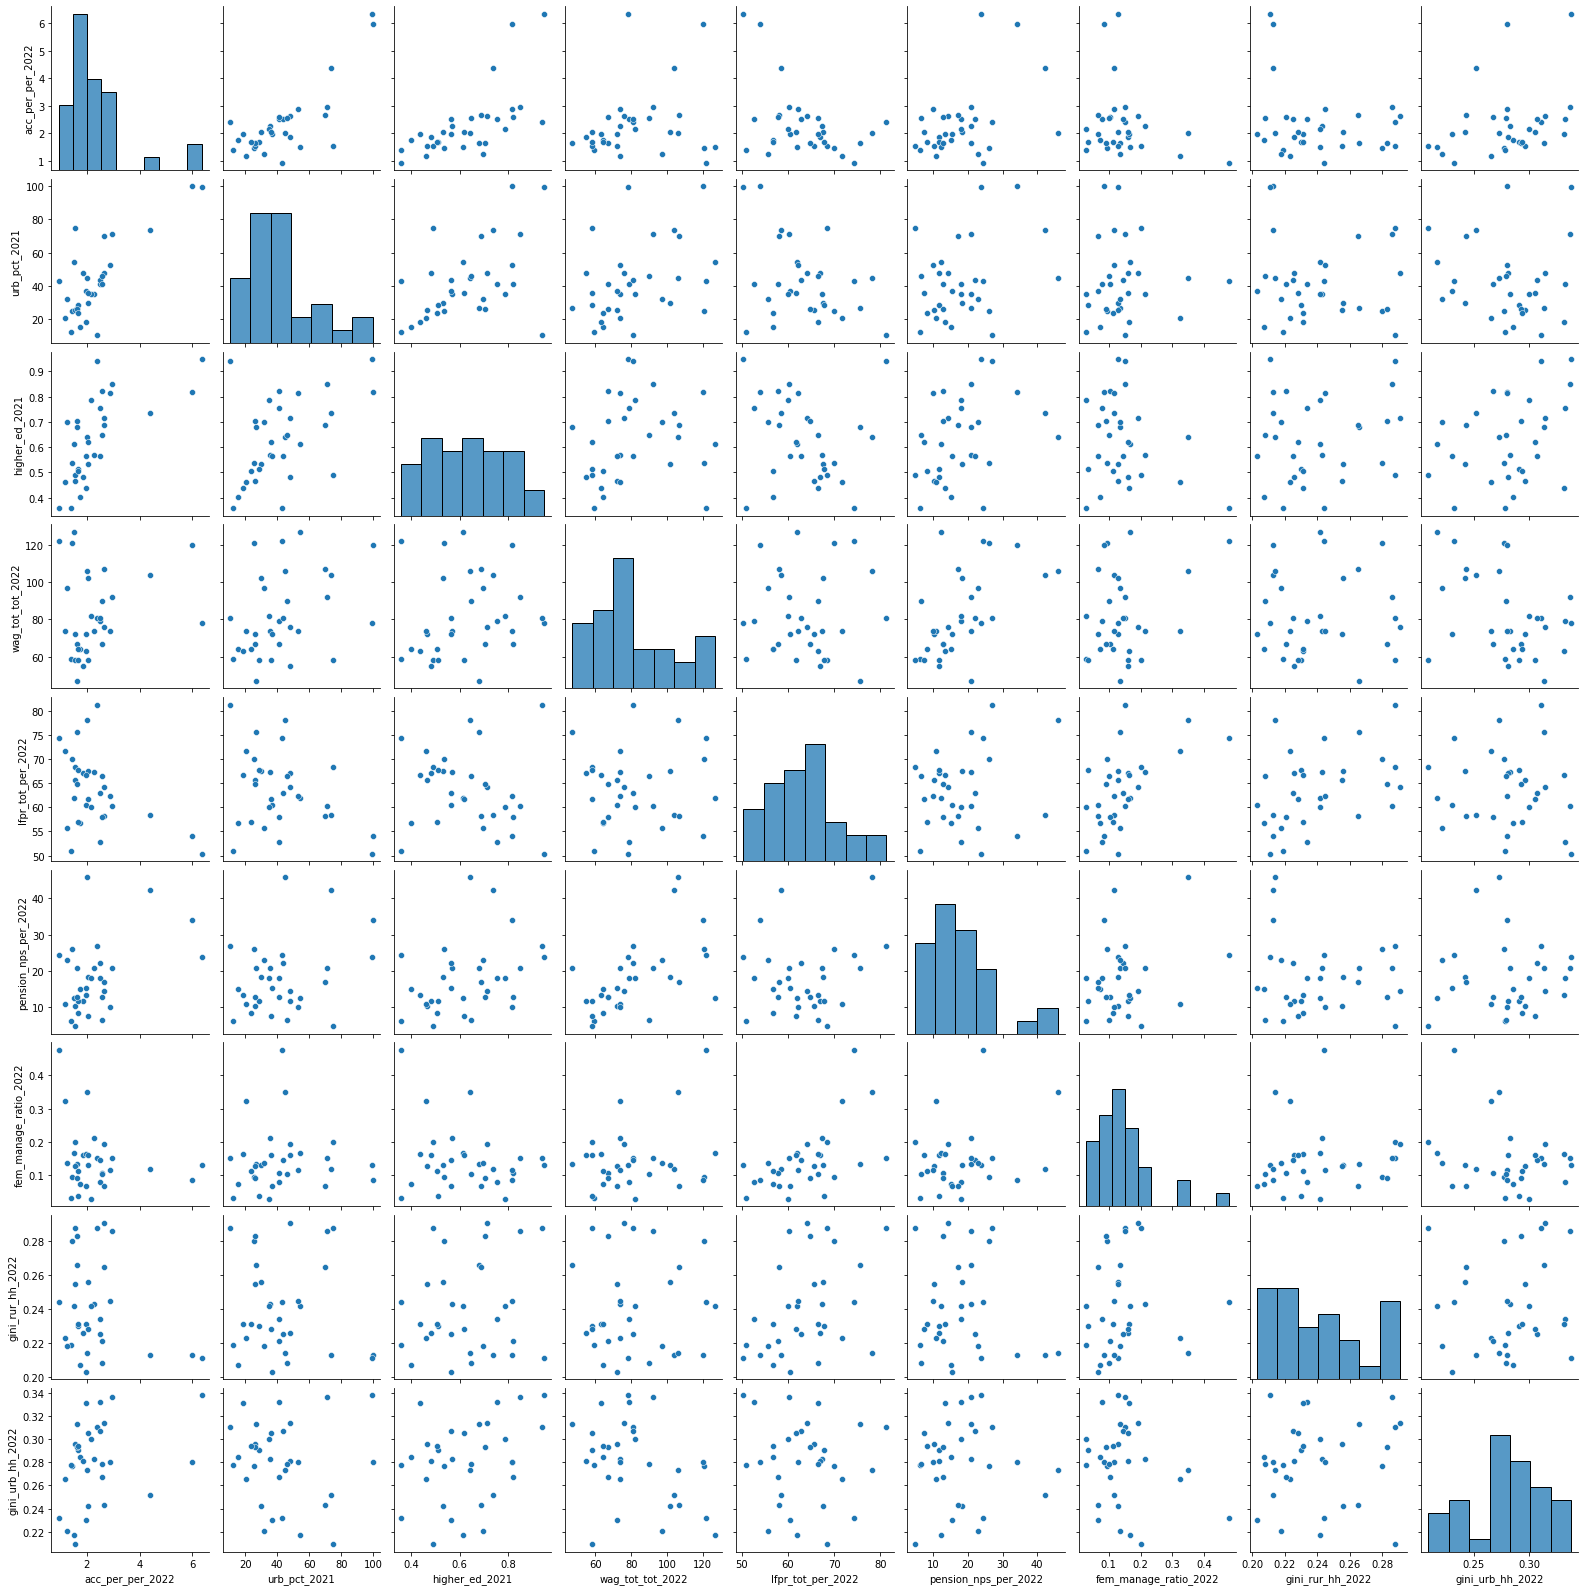

In [79]:
df_sub_xy = df_main[['acc_per_per_2022']+x_cols]
sns.pairplot(df_sub_xy)
plt.show()

The variance inflation factors, measuring how much variance in a given predictor is 
accounted for by other predictors, all look low. Ideally they are < 10, or better < 3. (The intercept term can be ignored.)

In [80]:
df_vif = add_constant(df_xx)
pd.Series([variance_inflation_factor(df_vif.values, ii) 
               for ii in range(df_vif.shape[1])], 
              index=df_vif.columns)

const                    304.814200
urb_pct_2021               2.050397
higher_ed_2021             2.118514
wag_tot_tot_2022           2.268360
lfpr_tot_per_2022          2.853207
pension_nps_per_2022       2.319962
fem_manage_ratio_2022      2.106525
gini_rur_hh_2022           1.625098
gini_urb_hh_2022           1.633974
dtype: float64

In [81]:
fitted_regression = smf.ols("acc_per_per_2022 ~ urb_pct_2021+higher_ed_2021+"
                            "wag_tot_tot_2022+lfpr_tot_per_2022+pension_nps_per_2022+"
                            "fem_manage_ratio_2022+gini_rur_hh_2022+gini_urb_hh_2022", 
                            data=df_sub_xy).fit()


The regression result itself shows an R^2 of 0.87. (Note the moderate condition number is an artifact of differences in scale in the predictors; normalizing the predictors returns the condition number to < 100.) Three covariates reach a 0.05 significance threshold:
- gini_rur_hh_2022 and gini_urb_hh_2022
    - these are measures of intra-state wealth inequality, in range [0,1]: 0.0 is perfect equality and 1.0 is complete inequality
    - the effect size is not very large; model coefficients indicate each 0.01 increase in urban Gini yields an increase of 0.1 accounts per person, while each 0.01 increase in rural Gini yields a decrease of 0.1 accounts per person
    - overall, this suggests inequalities among urban household expenditures improve account ownership, while inequalities among rural household expenditures decrease account ownership
- urb_pct_2021
    - this is the urban density of the state, in percent
    - the effect size is also not very large--for each 10% increase in state urbanization, the model suggests an increase in 0.35 accounts per person; however also consider that the states in the data vary in urbanization percent from about 10% to about 100%

In [82]:
print(fitted_regression.summary())

                            OLS Regression Results                            
Dep. Variable:       acc_per_per_2022   R-squared:                       0.875
Model:                            OLS   Adj. R-squared:                  0.833
Method:                 Least Squares   F-statistic:                     20.99
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           4.61e-09
Time:                        20:52:19   Log-Likelihood:                -18.064
No. Observations:                  33   AIC:                             54.13
Df Residuals:                      24   BIC:                             67.60
Df Model:                           8                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.67

### Linear model: economic opportunity <a name="lmeo"></a>

Another linear regression model is built, with the outcome variable one of the main economic opportunity measures available in the data. Given that rural / urban divides seem to be significant, with perhaps better outcomes among urban areas, rural areas are focused on. Here, the outcome used is the labor force participation rate of rural households (lfpr_rur_per_2022). Again, predictors were selected for likely impact after brief research. Further screening involved checking for pairwise correlations, and variance inflation factors (VIF).

In [83]:
# a set of selected predictors, based on what likely might affect rural labor force 
# participation, or rural unemployment
x_cols = ['urb_pct_2021', 'mgnrega_per_2022', 'higher_ed_2021',
          'num_12mo_dgt_00_22', 'wag_rur_rur_2022', 'gini_rur_hh_2022',
          'pension_nps_per_2022', 'pop_on_Aadhaar_pct', 'fem_manage_ratio_2022',
          'health_ins_2019']

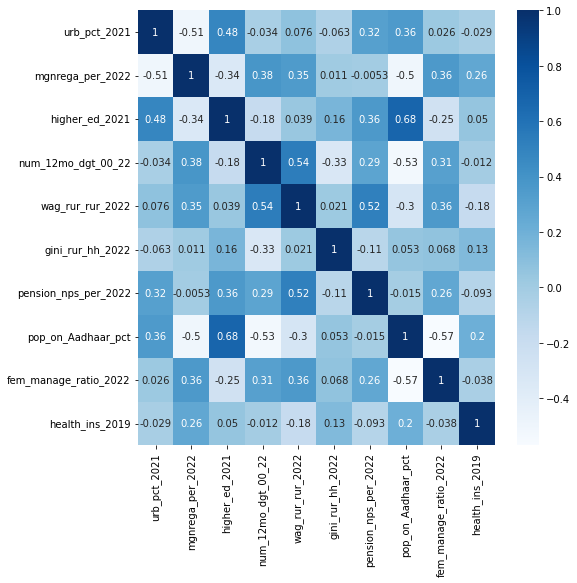

In [84]:
# check for correlations in predictors;
# correlations are fairly mild with a few above 0.50; 
# the biggest pairwise is pop_on_Aadhaar_pct and higher_ed_2021, at 0.68--will try the
# regression while leaving both these variables in
df_sub = df_main[x_cols]
corr_1 = df_sub.corr()
fig, ax = plt.subplots(figsize=(8,8)) 
sns.heatmap(corr_1,cmap="Blues",annot=True,ax=ax)
plt.show()

In [85]:
df_xx = df_main[x_cols]

For the scatterplot matrix of proposed variables, most variables do not show strong outliers. The most prominent outliers seem to be in the fem_manage_ratio_2022 variable. The fitted model could be checked for outlier influence (not done).

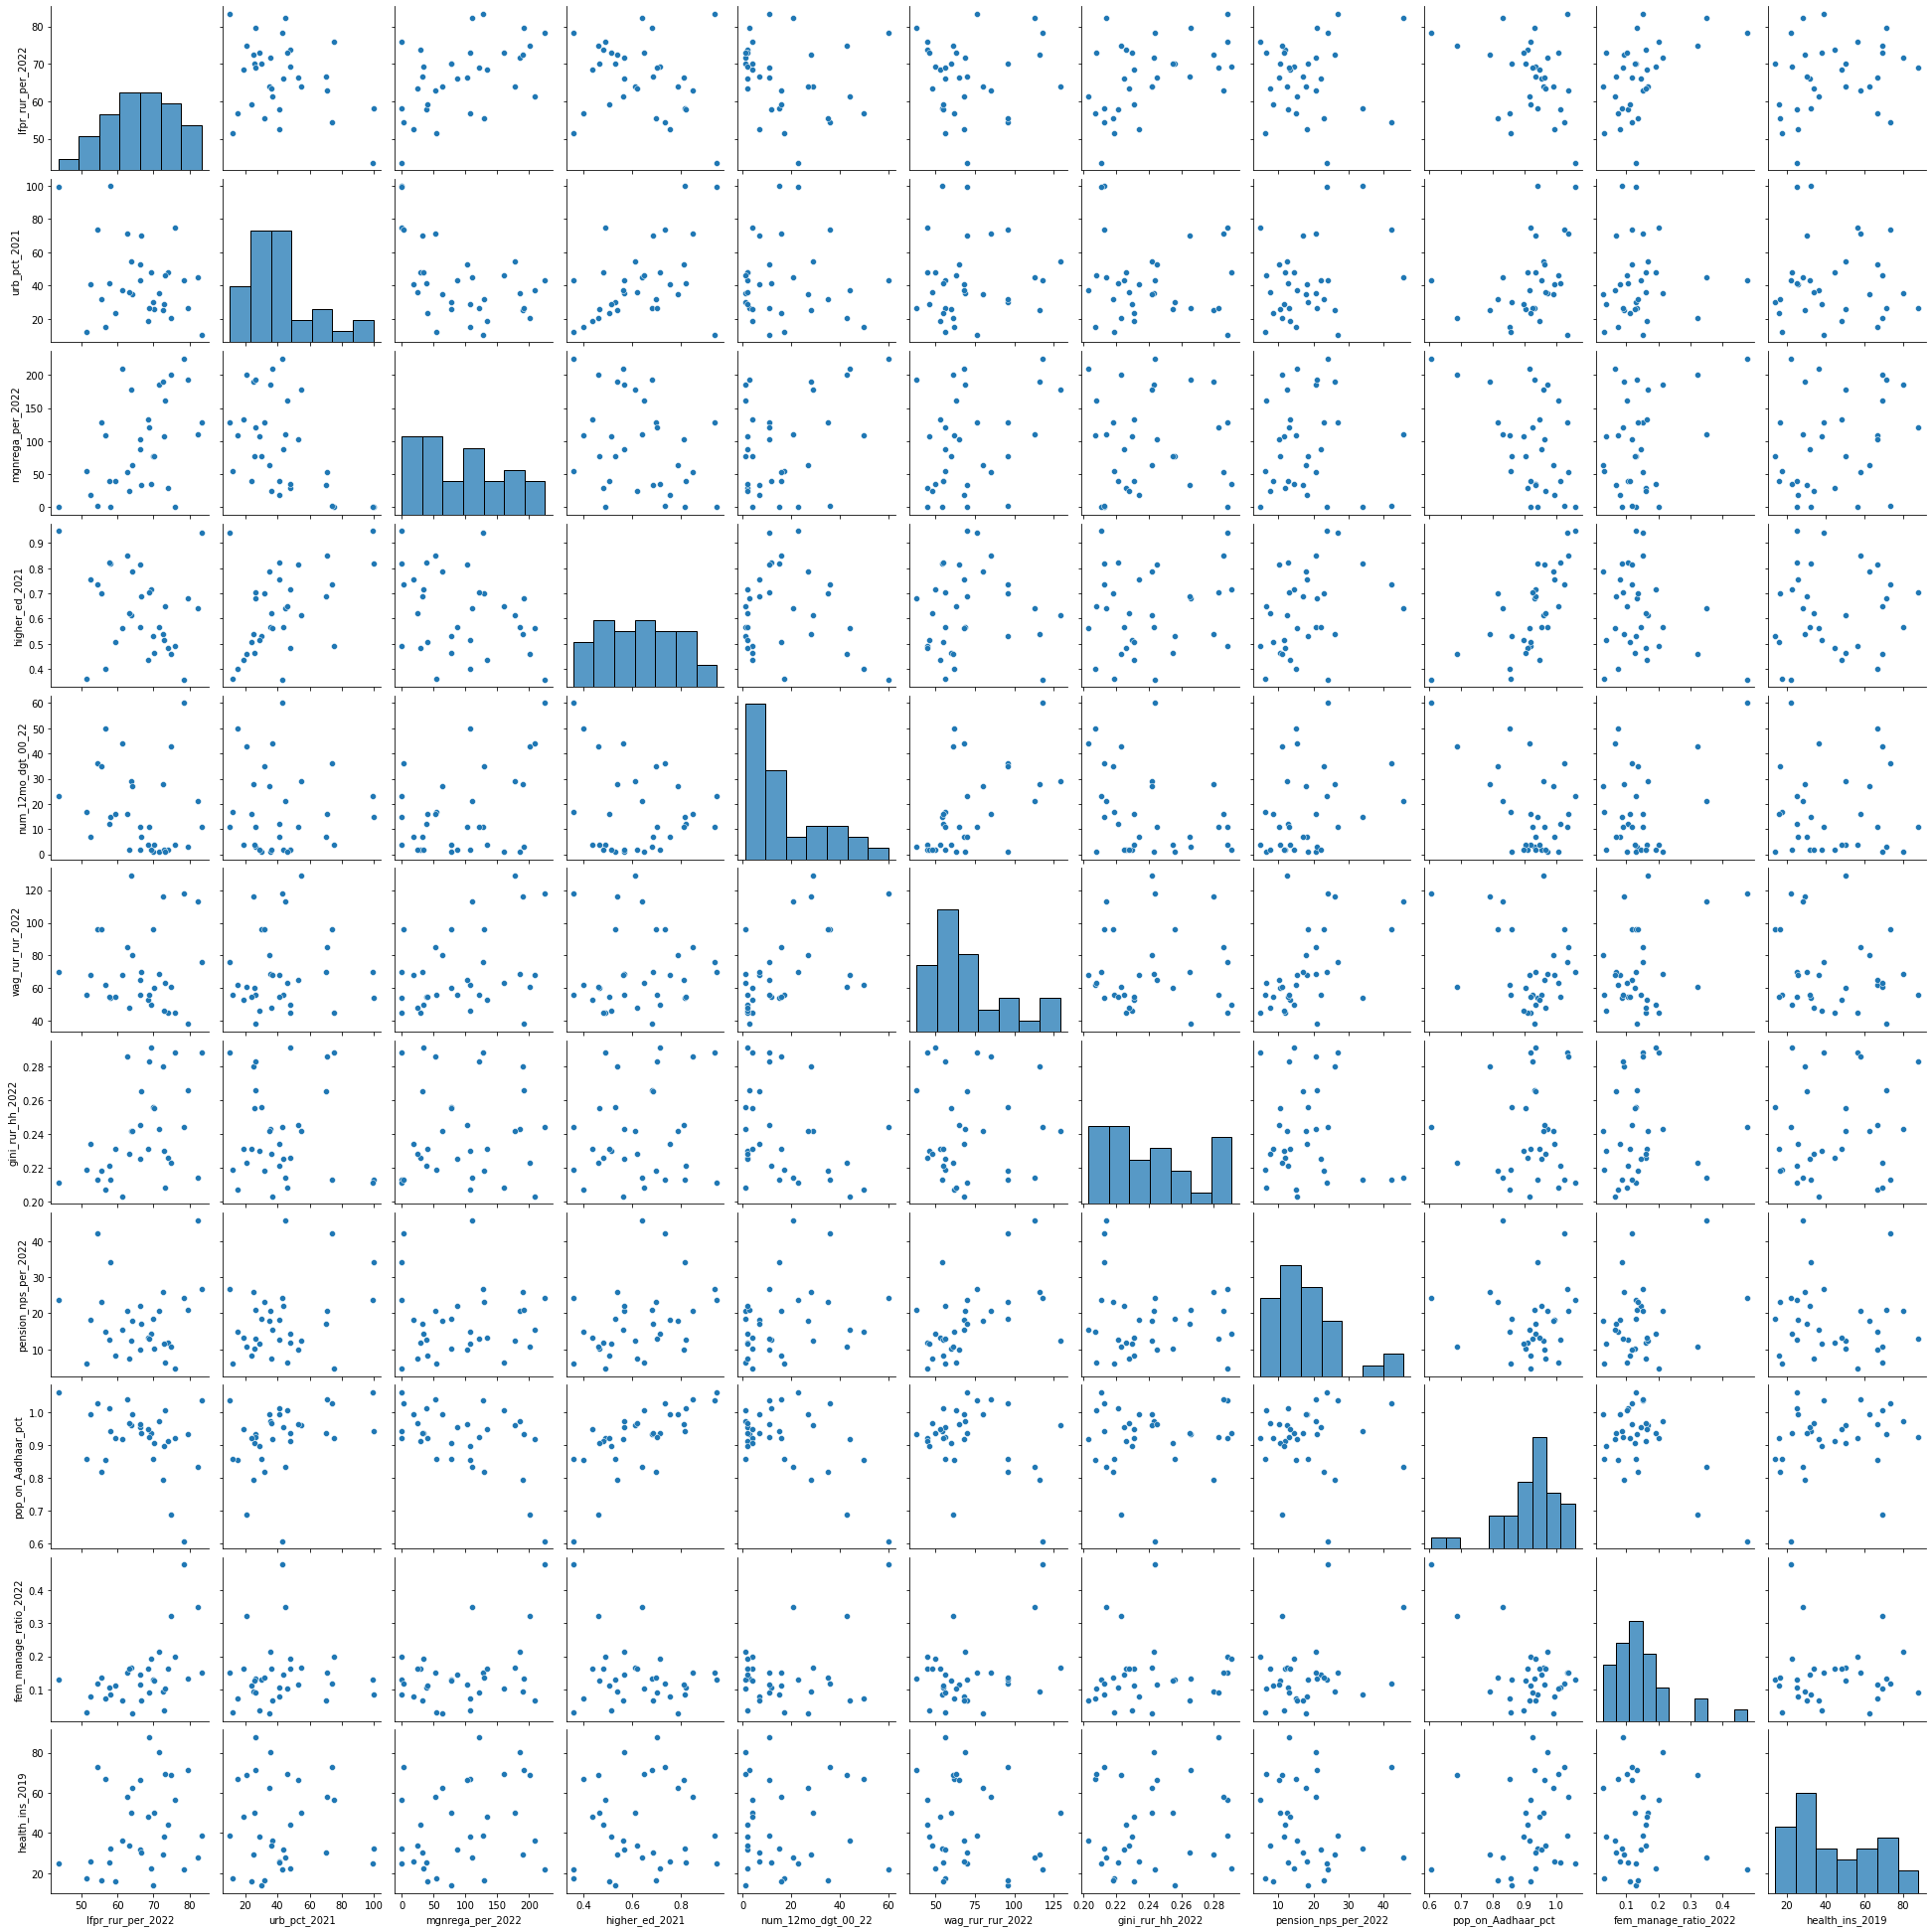

In [88]:
df_sub_xy = df_main[['lfpr_rur_per_2022']+x_cols]
sns.pairplot(df_sub_xy)
plt.show()

For variance inflation factors, the relationship/correlation between Aadhaar and higher_ed is noticeable--so there are some consequences to leaving both these in. It's somewhat subjective what cutoff to use, but will leave both variables in.

In [87]:
df_vif = add_constant(df_xx)
pd.Series([variance_inflation_factor(df_vif.values, ii) 
               for ii in range(df_vif.shape[1])], 
              index=df_vif.columns)

const                    587.192180
urb_pct_2021               2.027128
mgnrega_per_2022           2.670539
higher_ed_2021             3.245162
num_12mo_dgt_00_22         2.672610
wag_rur_rur_2022           2.494166
gini_rur_hh_2022           1.588755
pension_nps_per_2022       1.959238
pop_on_Aadhaar_pct         5.141706
fem_manage_ratio_2022      1.925465
health_ins_2019            1.687510
dtype: float64

In [89]:
fitted_regression = smf.ols("lfpr_rur_per_2022 ~ urb_pct_2021+mgnrega_per_2022+
                            "higher_ed_2021+num_12mo_dgt_00_22+wag_rur_rur_2022+"
                            "gini_rur_hh_2022+pension_nps_per_2022+pop_on_Aadhaar_pct+"
                            "fem_manage_ratio_2022+health_ins_2019", data=df_sub_xy).fit()


The regression result shows an R^2 of 0.75. (Again, the moderate condition number is an artifact of differences in scale in the predictors.) Four covariates reach a 0.05 significance threshold:
- the public-sponsored employment program, MGNREGA (mgnrega_per_2022)
    - the effect size is quite small, with a 10% increase in program offerings per unit population producing an increase of 0.005 percent in labor force particpation
    - this may merely reflect that MGNREGA program saturation is higher in areas that need it
    - this might also be improved by normalizing the number of MGNREGA recipients in the state by the number of rural people in the state estimated to be living in poverty, rather than state total population
- number of twelve-month droughts over 2000-2022 period (num_12mo_dgt_00_22)--for each drought event, the model predicts a decrease of 0.3% in rural labor force participation
- rural household wealth disparity (gini_rur_hh_2022)--this has a relatively large effect size, with each 0.01 increase in rural household expenditure inequality producing a one percent decrase in rural labor force participation
- female manager ratio (fem_manage_ratio_2022)--for each addition of 0.01 in female manager proportion, rural labor force participation increases by 0.3 percent

In [90]:
print(fitted_regression.summary())

                            OLS Regression Results                            
Dep. Variable:      lfpr_rur_per_2022   R-squared:                       0.756
Model:                            OLS   Adj. R-squared:                  0.646
Method:                 Least Squares   F-statistic:                     6.827
Date:                Mon, 21 Apr 2025   Prob (F-statistic):           8.97e-05
Time:                        20:59:40   Log-Likelihood:                -96.939
No. Observations:                  33   AIC:                             215.9
Df Residuals:                      22   BIC:                             232.3
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                56.72